# Set up and run a simple real-time calibration pipeline, RCAL.

In [1]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join('..','..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import matplotlib.pyplot as plt

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from data_models.polarisation import PolarisationFrame

from wrappers.serial.skycomponent.operations import create_skycomponent
from wrappers.serial.simulation.testing_support import create_blockvisibility_iterator
from wrappers.serial.simulation.configurations import create_named_configuration

from wrappers.serial.calibration.rcal import rcal


Define the data to be generated

In [2]:
lowcore = create_named_configuration('LOWBD2', rmax=750.0)
times = numpy.linspace(-3.0, +3.0, 7) * numpy.pi / 12.0
frequency = numpy.linspace(1.0e8, 1.50e8, 3)
channel_bandwidth = numpy.array([5e7, 5e7, 5e7])

# Define the component and give it some polarisation and spectral behaviour
f = numpy.array([100.0, 20.0, -10.0, 1.0])
flux = numpy.array([f, 0.8 * f, 0.6 * f])

phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox='J2000')
compdirection = SkyCoord(ra=17.0 * u.deg, dec=-36.5 * u.deg, frame='icrs', equinox='J2000')
comp = create_skycomponent(flux=flux, frequency=frequency, direction=compdirection)

In [3]:
def plotgain(gt, title=''):
    plt.clf()
    plt.plot(numpy.real(gt.gain[...,0,0]).flat, numpy.imag(gt.gain[...,0,0]).flat, '.')
    plt.plot(numpy.real(gt.gain[...,1,1]).flat, numpy.imag(gt.gain[...,1,1]).flat, '.')
    plt.title(title)
    plt.xlabel('Real part of gain')
    plt.ylabel('Imaginary part of gain')
    plt.show()

To do the simulation, we define a python generator that mimics an ingest. This generator creates, fills in visibilities, and applies gain errors. The generator only makes the data as needed. Hence the RCAL pipeline calls the generator repeatedly until all data have been constructed. 

To consume the data from the ingest, we define another generator, RCAL, that performs calibration and returns a gaintable.

RCAL is itself a python generator so nothing happens until the pipeline is iterated.

The simulation includes amplitude and phase errors of 0.01 and 0.1 radians. The plot shows the recovered gains.

Starting pipeline


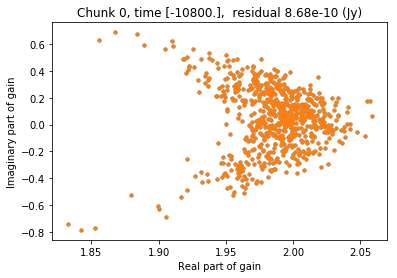

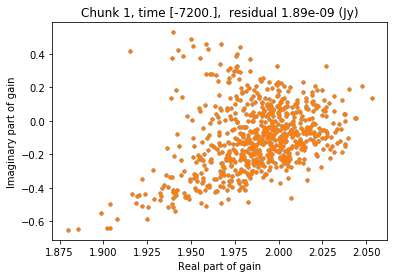

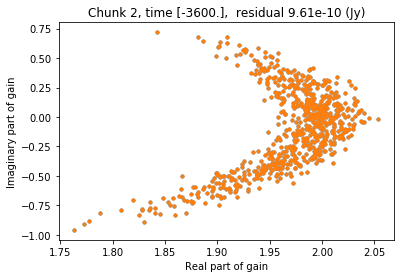

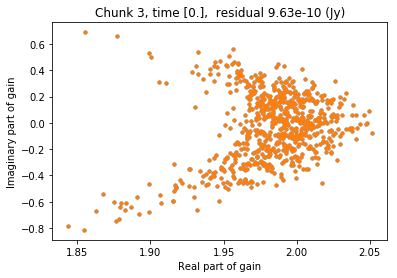

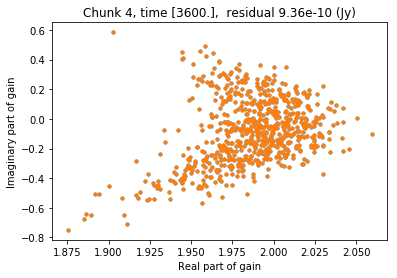

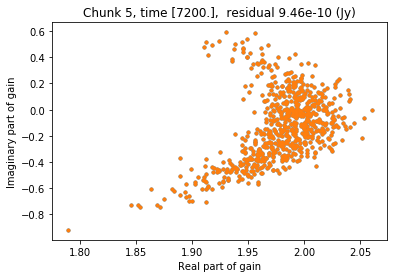

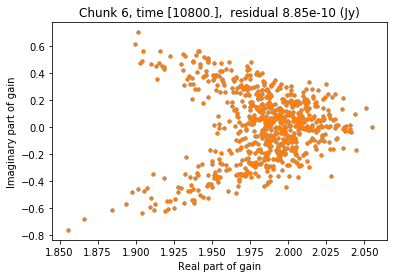

Ingest and RCAL pipelines are empty, stopping


In [4]:
ingest = create_blockvisibility_iterator(lowcore, times=times, 
                                         frequency=frequency, 
                                         channel_bandwidth=channel_bandwidth, phasecentre=phasecentre, 
                                         weight=1, polarisation_frame=PolarisationFrame('linear'), 
                                         integration_time=1.0, number_integrations=1,
                                         components=comp, phase_error=0.1, amplitude_error=0.01)

rcal_pipeline = rcal(vis=ingest, components=comp, phase_only=False)

print("Starting pipeline")
for igt, gt in enumerate(rcal_pipeline):
    plotgain(gt, title="Chunk %d, time %s,  residual %.3g (Jy)" % (igt, numpy.unique(gt.time), 
                                                                numpy.average(gt.residual)))
    
print("Ingest and RCAL pipelines are empty, stopping")